# DATA WRANGLING PROJECT 

## International Visitors
This notebook consists of the wrangling involved in `International Visitors Data`

## Section 1 - Wrangling the International Visitors data

The steps are as follows:
 1. Treating the missing values
 2. Aggregating the columns
 3. Reshaping the dataframe into common structure

In [460]:
#Loading the required libraries:
library(tidyverse)
library(sqldf)
library(stringr)
library(data.table)
library(ggplot2)
library(gganimate)
library(gapminder)

### Treating the `Missing Values`:

In [461]:
#Reading CSV file into dataframe

df <- read_csv("vw_IVSSurveyMainHeader.csv")

#Selecting the required columns and Filtering the records from the dataframe into new dataframe to proceed further

df <- df %>% 
        select(Year,ArrivalMonth,CORNextYr,Airport,POV,AgeRange,MainAccommTypeUsed,LengthOfStay,TotalSpendInNZ,Gender,Qtr) %>% 
        filter(Year >= 2014)

unclean_df <- df
unclean_df %>% glimpse

Parsed with column specification:
cols(
  .default = col_character(),
  SurveyResponseID = col_double(),
  ResponseID = col_double(),
  NumberOfVisitsToNZ = col_double(),
  ArrivalDay = col_double(),
  ArrivalYear = col_double(),
  NoDaysInNZ = col_double(),
  FlightClass = col_logical(),
  VisitedAUSonvisit = col_logical(),
  NoDaysInAustralia = col_logical(),
  NoDaysInAustraliaNotKnown = col_logical(),
  GroupTour = col_logical(),
  PackageDeal = col_logical(),
  PkgIncludedAirfare = col_logical(),
  NoNightsOtherCountry = col_double(),
  TravelParty = col_logical(),
  NoPeopleOver15 = col_double(),
  NoPeopleunder15 = col_double(),
  TotalCost = col_double(),
  NoPeopleSpendFor = col_double(),
  LengthOfStay = col_double()
  # ... with 11 more columns
)

See spec(...) for full column specifications.

Warning message:
"47344 parsing failures.
   row               col           expected                        actual                         file
120186 VisitedAUSonvisit 1/0/T/F/TRUE/F

Observations: 51,140
Variables: 11
$ Year               <dbl> 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, ...
$ ArrivalMonth       <chr> "March", "March", "March", "April", "January", "...
$ CORNextYr          <chr> "United States of America", "United States of Am...
$ Airport            <chr> "Auckland", "Auckland", "Auckland", "Auckland", ...
$ POV                <chr> "Holiday / vacation", "Holiday / vacation", "Hol...
$ AgeRange           <chr> "65 - 69", "55 - 59", "60 - 64", "25 - 29", "30 ...
$ MainAccommTypeUsed <chr> "Bed and Breakfast", "Luxury Accommodation, 5-st...
$ LengthOfStay       <dbl> 17, 23, 14, 6, 75, 8, 14, 33, 7, 27, 5, 6, 5, 36...
$ TotalSpendInNZ     <dbl> 7.092227e+02, 1.418445e+04, 9.078051e+03, 1.8991...
$ Gender             <chr> "Female", "Male", "Male", "Male", "Female", "Mal...
$ Qtr                <chr> "2017 2", "2017 2", "2017 2", "2017 2", "2017 2"...


In [462]:
#Replaced the 'NA' value as 'NOT SURE', since it is one of the categorical value used in survey for Accomodation Type 

unclean_df$MainAccommTypeUsed <- as.character(unclean_df$MainAccommTypeUsed)
unclean_df$MainAccommTypeUsed <- ifelse(is.na(unclean_df$MainAccommTypeUsed),'NOT SURE', unclean_df$MainAccommTypeUsed)
unclean_df %>% plyr::count("MainAccommTypeUsed")   # using the library "plyr" for count function

MainAccommTypeUsed,freq
<chr>,<int>
A house you own,605
Another place where you pay to park a caravan or campervan / motorhome overnight,396
Backpackers,2325
Bed and Breakfast,1493
Camping at a National Park / Department of Conservation camping ground,656
Farm-stay or Home-stay,652
"Free camping - staying at a place that is NOT an official camp site, in a tent, caravan, campervan / motorhome",515
Hotel,10744
House / flat that you paid some rent for,3878


In [463]:
#Replaced the NA value in Arrival Month as Not specified

unclean_df <- unclean_df %>%
                  mutate(ArrivalMonth = replace(ArrivalMonth, is.na(ArrivalMonth), "Not Specified"))
#unclean_df %>% count("ArrivalMonth")

In [464]:
#Grouped by the specific columns and found the average value of stay from a Lengthofstay column for that particular category
#and used that to fill any NULL value records within that category.
#Here the category means, the first 5 columns in our dataframe i.e. Year,ArrivalMonth,CORNextYr,Airport,POV: 

aggr_stay <- sqldf("select Year,ArrivalMonth,CORNextYr,Airport,POV, avg(LengthOfStay) 
                    as avg_stay,Qtr from unclean_df group by Year,ArrivalMonth,CORNextYr,Airport,POV")
aggr_stay %>% head()

Year,ArrivalMonth,CORNextYr,Airport,POV,avg_stay,Qtr
<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
2014,April,Argentina,Auckland,Holiday / vacation,243.000000,2014 4
2014,April,Australia,Auckland,Business,5.625000,2014 2
2014,April,Australia,Auckland,Conference / convention,4.500000,2014 2
2014,April,Australia,Auckland,Education,6.000000,2014 2
2014,April,Australia,Auckland,Holiday / vacation,8.142857,2014 2
2014,April,Australia,Auckland,Other,10.500000,2014 2


In [465]:
#joining the two dataframes unclean_df and aggr based on the category (year, arrivalmonth, CORNextyr, Airport and POV)

sam1 <- unclean_df
sam2 <- aggr_stay
join <- sqldf("select * from sam1 left outer join sam2 on sam1.Year = sam2.Year
               where sam1.ArrivalMonth = sam2.ArrivalMonth and sam1.CORNextYr = sam2.CORNextYr and sam1.Airport = sam2.Airport and sam1.POV = sam2.POV")
join %>% glimpse

Observations: 51,140
Variables: 18
$ Year               <dbl> 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, ...
$ ArrivalMonth       <chr> "March", "March", "March", "April", "January", "...
$ CORNextYr          <chr> "United States of America", "United States of Am...
$ Airport            <chr> "Auckland", "Auckland", "Auckland", "Auckland", ...
$ POV                <chr> "Holiday / vacation", "Holiday / vacation", "Hol...
$ AgeRange           <chr> "65 - 69", "55 - 59", "60 - 64", "25 - 29", "30 ...
$ MainAccommTypeUsed <chr> "Bed and Breakfast", "Luxury Accommodation, 5-st...
$ LengthOfStay       <dbl> 17, 23, 14, 6, 75, 8, 14, 33, 7, 27, 5, 6, 5, 36...
$ TotalSpendInNZ     <dbl> 7.092227e+02, 1.418445e+04, 9.078051e+03, 1.8991...
$ Gender             <chr> "Female", "Male", "Male", "Male", "Female", "Mal...
$ Qtr                <chr> "2017 2", "2017 2", "2017 2", "2017 2", "2017 2"...
$ Year..12           <dbl> 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, ...
$ ArrivalMonth..1

In [466]:
#Replacing the missing values in Lengthofstay column as Not specified

join <- join %>%
            mutate(LengthOfStay = replace(LengthOfStay, is.na(LengthOfStay), "Not Specified"))

#Replacing the Not specified values in Lengthofstay column with average value in ang_stay column

position <- join$LengthOfStay %in% "Not Specified"
join[position,c(8)] <- join[position,c(17)]

In [467]:
#Selecting the required columns from a join dataframe into final dataframe

final <- join %>% select(c(1:11))
final %>% glimpse

Observations: 51,140
Variables: 11
$ Year               <dbl> 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, ...
$ ArrivalMonth       <chr> "March", "March", "March", "April", "January", "...
$ CORNextYr          <chr> "United States of America", "United States of Am...
$ Airport            <chr> "Auckland", "Auckland", "Auckland", "Auckland", ...
$ POV                <chr> "Holiday / vacation", "Holiday / vacation", "Hol...
$ AgeRange           <chr> "65 - 69", "55 - 59", "60 - 64", "25 - 29", "30 ...
$ MainAccommTypeUsed <chr> "Bed and Breakfast", "Luxury Accommodation, 5-st...
$ LengthOfStay       <chr> "17", "23", "14", "6", "75", "8", "14", "33", "7...
$ TotalSpendInNZ     <dbl> 7.092227e+02, 1.418445e+04, 9.078051e+03, 1.8991...
$ Gender             <chr> "Female", "Male", "Male", "Male", "Female", "Mal...
$ Qtr                <chr> "2017 2", "2017 2", "2017 2", "2017 2", "2017 2"...


In [468]:
#Removed 21 rows which don't have values (NA)in Number_of_Days column

final[complete.cases(final[ ,"LengthOfStay"]),] %>% glimpse()

#Arranged column in requierd order

final <- final %>% select("Year","ArrivalMonth","Qtr","CORNextYr","Airport","POV","AgeRange","MainAccommTypeUsed","LengthOfStay","TotalSpendInNZ","Gender")
final %>% head()

Observations: 51,119
Variables: 11
$ Year               <dbl> 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, ...
$ ArrivalMonth       <chr> "March", "March", "March", "April", "January", "...
$ CORNextYr          <chr> "United States of America", "United States of Am...
$ Airport            <chr> "Auckland", "Auckland", "Auckland", "Auckland", ...
$ POV                <chr> "Holiday / vacation", "Holiday / vacation", "Hol...
$ AgeRange           <chr> "65 - 69", "55 - 59", "60 - 64", "25 - 29", "30 ...
$ MainAccommTypeUsed <chr> "Bed and Breakfast", "Luxury Accommodation, 5-st...
$ LengthOfStay       <chr> "17", "23", "14", "6", "75", "8", "14", "33", "7...
$ TotalSpendInNZ     <dbl> 7.092227e+02, 1.418445e+04, 9.078051e+03, 1.8991...
$ Gender             <chr> "Female", "Male", "Male", "Male", "Female", "Mal...
$ Qtr                <chr> "2017 2", "2017 2", "2017 2", "2017 2", "2017 2"...


Year,ArrivalMonth,Qtr,CORNextYr,Airport,POV,AgeRange,MainAccommTypeUsed,LengthOfStay,TotalSpendInNZ,Gender
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
2017,March,2017 2,United States of America,Auckland,Holiday / vacation,65 - 69,Bed and Breakfast,17,709.2227,Female
2017,March,2017 2,United States of America,Auckland,Holiday / vacation,55 - 59,"Luxury Accommodation, 5-star Hotel, Luxury Lodge",23,14184.4540,Male
2017,March,2017 2,United States of America,Auckland,Holiday / vacation,60 - 64,Hotel,14,9078.0505,Male
2017,April,2017 2,Canada,Auckland,Holiday / vacation,25 - 29,Hotel,6,1899.1711,Male
2017,January,2017 2,Australia,Auckland,Visiting friends / relatives,30 - 34,Staying with family or friends,75,1000.0000,Female
2017,March,2017 2,United States of America,Auckland,Visiting friends / relatives,45 - 49,Staying with family or friends,8,9929.1178,Male


In [469]:
#Renaming the columns
clean_df <- dplyr::rename(final, 
                     Year = Year,
                     Month = ArrivalMonth,
                     Quarter = Qtr,
                     Country = CORNextYr,
                     NZ_City = Airport,
                     Visit_Purpose = POV,
                     Number_of_People = Gender,
                     Number_of_Days = LengthOfStay,
                     Accommadation_Type = MainAccommTypeUsed,
                     Age_Range = AgeRange,
                     Total_Spending = TotalSpendInNZ,      
                )
clean_df$Number_of_Days <- as.double(clean_df$Number_of_Days)

The below code can be executed if you want to see the output of the data after cleaning.

In [470]:
# Export the final(cleaned) dataframe into csv format

#write_csv(final,"Tourism_Last5.csv")

### Aggregating the columns
This step involves aggregating the last 5 columns of the dataframe by the first 5 columns in each level separately.

Now, Lets create a function to aggregate each columns and then automate it. 

In [471]:
#Creating a function to calculate Average days spent
avgdays_c <- function(df){
                aggr_days <- df %>% 
                select(c(1:6,9)) %>%
                group_by(Year,Month,Quarter,Country,NZ_City,Visit_Purpose) %>%
                dplyr::summarise(AvgDaysSpent = mean(Number_of_Days))
                return(aggr_days)
                    }


In [472]:
#creating functions to calculate the preferred accommodation type
getmode <- function(v) {
   uniqv <- unique(v)
   uniqv[which.max(tabulate(match(v, uniqv)))]
}

hotel_c <- function(df){
    
            select_hotel <- df %>% 
                    select(c(1:6,8))

            aggr_hotel <- aggregate(x = select_hotel, by = list(select_hotel$Year,select_hotel$Month,select_hotel$Quarter,
                                                                select_hotel$Country,select_hotel$NZ_City,select_hotel$Visit_Purpose),
                                                                FUN = getmode) %>%
                          select(-c(1,2,3,4,5,6)) %>%
                          arrange(desc(Year))
            return(aggr_hotel)
    }

In [473]:
#creating a function to calculate the Average Age

age_calc <- function(df) {
df %>%
    mutate(Age = case_when(df$Age_Range == "Under 20" ~ "20",
           df$Age_Range == "20 - 24" ~ "22",
           df$Age_Range == "25 - 29" ~ "27",
           df$Age_Range == "30 - 34" ~ "32",
           df$Age_Range == "35 - 39" ~ "37",
           df$Age_Range == "40 - 44" ~ "42",
           df$Age_Range == "45 - 49" ~ "47",
           df$Age_Range == "50 - 54" ~ "52",
           df$Age_Range == "55 - 59" ~ "57",
           df$Age_Range == "60 - 64" ~ "62",
           df$Age_Range == "65 - 69" ~ "67",
           df$Age_Range == "70 - 74" ~ "72",
           df$Age_Range == "75 or older" ~ "80",
           df$Age_Range == "Rather not say" ~ "40")) %>%
        mutate (Age = as.numeric(Age)) %>%
        group_by(Year,Month,Quarter,Country,NZ_City,Visit_Purpose) %>%
        summarise(Age = mean(Age))
}

age_c <- function(df) {
        select_age <- df %>% 
                        select(c(1:7))

        aggr_age <- select_age %>% 
                        age_calc()
        return(aggr_age)
    }

In [474]:
#creating function to calculate the Average spendings

avgspend_c <- function(df){
                aggr_spend <- df %>% 
                                select(c(1:6,10)) %>%
                                group_by(Year,Month,Quarter,Country,NZ_City,Visit_Purpose) %>%
                                summarise(AvgSpending = mean(Total_Spending))
                return(aggr_spend)
    }

In [475]:
#creating a function to calculate the Number of people

nppl_c <- function(df) {
            aggr_ppl <- df %>% 
                        select(c(1:6,11)) %>%
                        group_by(Year,Month,Quarter,Country,NZ_City,Visit_Purpose) %>%
                        summarise(Number_of_People = n())
                        return(aggr_ppl)
                        }

In [476]:
#consolidating all the functions into one function

#df_initial
add_aggrcolumns <- function(df) {
#df1
df1 <- df %>% hotel_c()

#df2
df2 <- df %>% age_c() 

#df3
df3 <- df %>% avgdays_c()

#df4
df4 <- df %>% avgspend_c()

#df5
df5 <- df %>% nppl_c()

#mergeall
df_final <- Reduce(function(x, y) merge(x, y), list(df1, df2, df3, df4, df5))

#df_final
return(df_final)    
    
  }

After creating all the functions, Lets apply it to the cleaned dataframe to get the desired structure

In [477]:
#Assigning the final aggregated clean dataframe to the new data frame for later use.
visitors_data <- clean_df %>% add_aggrcolumns()

In [478]:
visitors_data %>% glimpse
write_csv(visitors_data,"IVS.csv")    # Exported to view the output

Observations: 13,121
Variables: 11
$ Year               <dbl> 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, ...
$ Month              <chr> "April", "April", "April", "April", "April", "Ap...
$ Quarter            <chr> "2014 1", "2014 1", "2014 1", "2014 2", "2014 2"...
$ Country            <chr> "Czech Republic", "England", "France", "Australi...
$ NZ_City            <chr> "Auckland", "Christchurch", "Auckland", "Aucklan...
$ Visit_Purpose      <chr> "Other", "Holiday / vacation", "Other", "Busines...
$ Accommadation_Type <chr> "Backpackers", "Motel, Motor Inn or Serviced Apa...
$ Age                <dbl> 22.00000, 67.00000, 27.00000, 39.50000, 30.75000...
$ AvgDaysSpent       <dbl> 352.000000, 22.000000, 357.000000, 5.625000, 4.5...
$ AvgSpending        <dbl> 22000.0000, 3662.9903, 5000.0000, 1122.4051, 119...
$ Number_of_People   <int> 1, 1, 1, 8, 4, 1, 28, 2, 34, 3, 42, 15, 1, 1, 17...


### Section - 2: Building the data model

Inorder to avoid confusion, rest of the data sets are wrangled in a different notebook. To get the ouput files of those data sets run the respective notebook files as mentioned in <b>`read_me.txt`</b> file.

#### `After executing all the other notebooks , go to section - 3 given below.`

### Section - 3: Merging the datasets and Visualization

This section involves the step of merging other entities such as FoodPrice, HouseRental, Crime with International Visitors (IVS) data to create visualizations and make inferences from it.

The steps are as follows:
   1. Here for each visualization we will be joining different datasets as required to plot the graph
   2. Plotting the graph
    
Since we have more number of records in the final dataframe of IVS, we will be filtering with certain fields such as Year and NZ_City for the purpose of visualization.

With the final data model, as mentioned in the project report we can join all four entities with the key fields such as Year, Month, Quarter, NZ_City for further analysis. This is why we shaped all the datasets into a common structure. 

### Visualization on IVS Data

First, Lets create plots and inferences from IVS data followed by the final data model.

In [479]:
#creating a dataframe for plotting
vis1 <- visitors_data  %>% select(Year,NZ_City,Number_of_People) %>% group_by(Year,NZ_City) %>% summarise(Total_Visitors = sum(Number_of_People))

vis1 %>% head()

Year,NZ_City,Total_Visitors
<dbl>,<chr>,<int>
2014,Auckland,6913
2014,Christchurch,2192
2014,Queenstown,353
2014,Wellington,575
2015,Auckland,6514
2015,Christchurch,2227


Saving 6.67 x 6.67 in image



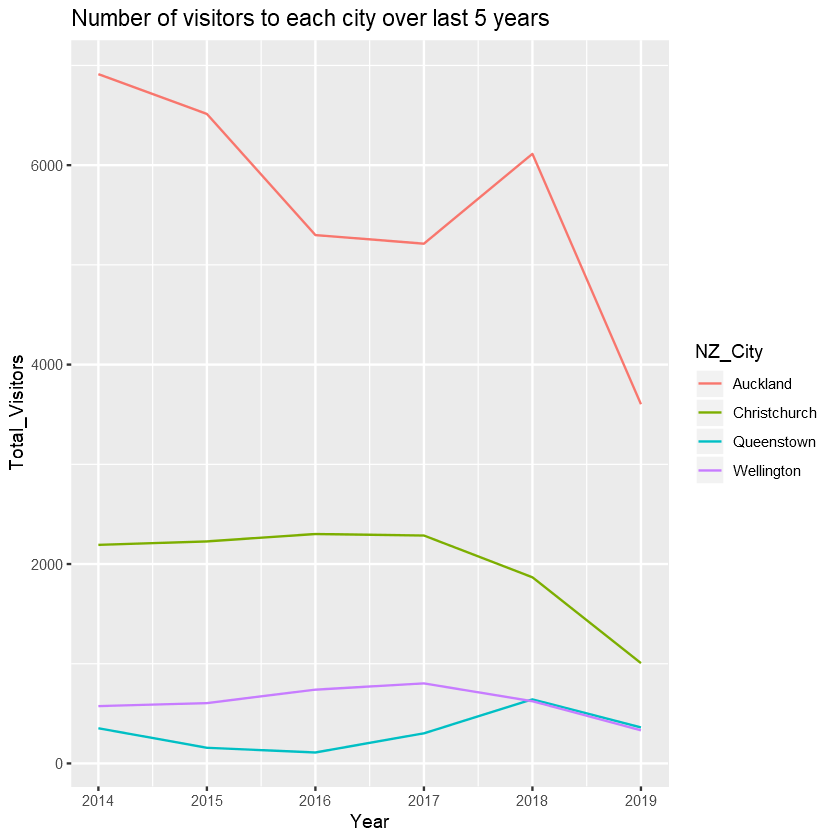

In [480]:
# A line chart that compares the trend of number of visitors to each city over the last 5 years.

vis_1 <- ggplot(vis1, aes(x = Year, y = Total_Visitors))
vis_1 + geom_line(aes(color = NZ_City)) + ggtitle("Number of visitors to each city over last 5 years")
ggsave("Number of visitors to each city over last 5 years.pdf")

In [481]:
#creating a dataframe for plotting bar chart
vis2 <- visitors_data %>% filter(Year == 2018) %>% filter(NZ_City == "Christchurch" | NZ_City == "Auckland" ) %>% 
        select(Year,NZ_City,Country,Number_of_People) %>% group_by(Year,NZ_City,Country) %>% 
        summarise(Total_Visitors = sum(Number_of_People)) %>% arrange(desc(Total_Visitors)) %>%
        top_n(5)

vis2

Selecting by Total_Visitors



Year,NZ_City,Country,Total_Visitors
<dbl>,<chr>,<chr>,<int>
2018,Auckland,"China, People's Republic of",881
2018,Auckland,Australia,738
2018,Auckland,Japan,639
2018,Auckland,United States of America,628
2018,Christchurch,Australia,625
2018,Auckland,England,537
2018,Christchurch,England,239
2018,Christchurch,Germany,164
2018,Christchurch,"China, People's Republic of",123


Saving 6.67 x 6.67 in image



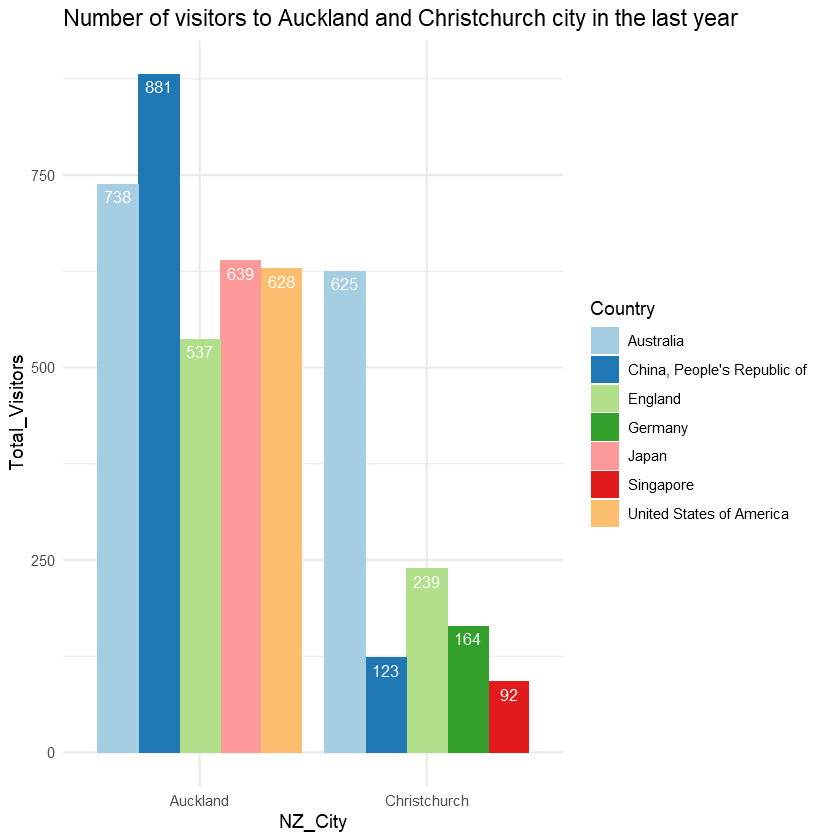

In [482]:
#A grouped bar chart that compares the number of visitors to Auckland and Christchurch city in the last year.

ggplot(data= vis2, aes(x=NZ_City, y= Total_Visitors, fill=Country)) +
  geom_bar(stat="identity", position=position_dodge())+
  geom_text(aes(label= Total_Visitors), vjust=1.6, color="white",
            position = position_dodge(0.9), size=3.5)+
  scale_fill_brewer(palette="Paired")+
  ggtitle("Number of visitors to Auckland and Christchurch city in the last year") +
  theme_minimal()
ggsave("Number of visitors to Auckland and Christchurch city in the last year.pdf")

In [483]:
#creating a dataframe for plotting pie chart
vis3 <- visitors_data %>% filter(Year == 2018) %>% filter(NZ_City == "Christchurch") %>% 
        select(Year,NZ_City,Visit_Purpose,Number_of_People) %>% group_by(Year,NZ_City,Visit_Purpose) %>% 
        summarise(Total_Visitors = sum(Number_of_People)) %>% arrange(desc(Total_Visitors)) %>%
        top_n(5)

vis3

Selecting by Total_Visitors



Year,NZ_City,Visit_Purpose,Total_Visitors
<dbl>,<chr>,<chr>,<int>
2018,Christchurch,Holiday / vacation,1390
2018,Christchurch,Visiting friends / relatives,351
2018,Christchurch,Business,60
2018,Christchurch,Other,29
2018,Christchurch,Education,25


Saving 6.67 x 6.67 in image



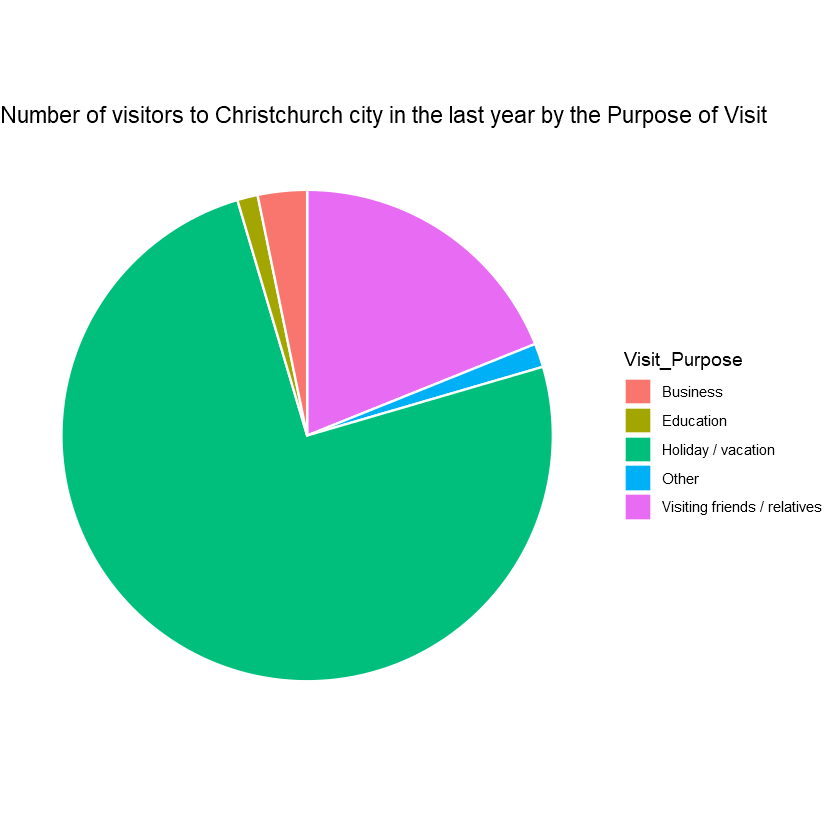

In [484]:
#A pie that compares the number of visitors to Christchurch city in the last year by the Purpose of Visit.

ggplot(vis3, aes(x = "", y = Total_Visitors , fill = Visit_Purpose)) +
  geom_bar(width = 1, stat = "identity", color = "white") +
  coord_polar("y", start = 0)+
  ggtitle("Number of visitors to Christchurch city in the last year by the Purpose of Visit") +
  theme_void()
ggsave("Number of visitors to Christchurch city in the last year by the Purpose of Visit.pdf")

In [485]:
#creating a dataframe for plotting pie chart
vis4 <- visitors_data %>% filter(Year == 2018) %>% filter(NZ_City == "Auckland") %>% 
        select(Year,NZ_City,Visit_Purpose,Number_of_People) %>% group_by(Year,NZ_City,Visit_Purpose) %>% 
        summarise(Total_Visitors = sum(Number_of_People)) %>% arrange(desc(Total_Visitors)) %>%
        top_n(5)

vis4

Selecting by Total_Visitors



Year,NZ_City,Visit_Purpose,Total_Visitors
<dbl>,<chr>,<chr>,<int>
2018,Auckland,Holiday / vacation,3950
2018,Auckland,Visiting friends / relatives,1340
2018,Auckland,Business,347
2018,Auckland,Other,203
2018,Auckland,Education,138


Saving 6.67 x 6.67 in image



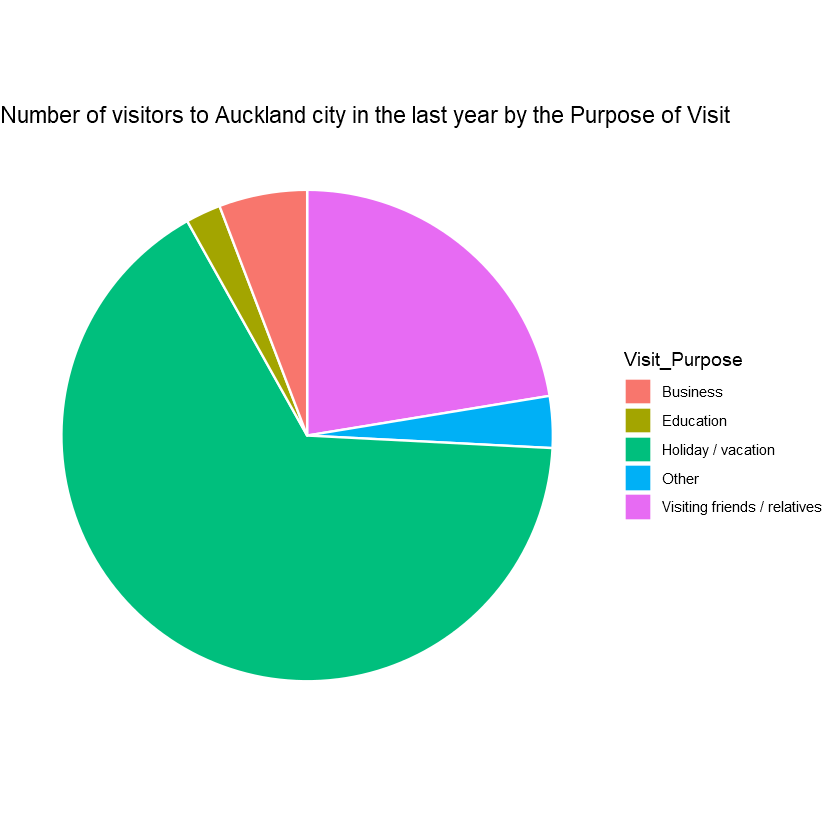

In [486]:
#A pie that compares the number of visitors to Auckland city in the last year by the Purpose of Visit.

ggplot(vis4, aes(x = "", y = Total_Visitors , fill = Visit_Purpose)) +
  geom_bar(width = 1, stat = "identity", color = "white") +
  coord_polar("y", start = 0)+
  ggtitle("Number of visitors to Auckland city in the last year by the Purpose of Visit") +
  theme_void()
ggsave("Number of visitors to Auckland city in the last year by the Purpose of Visit.pdf")

### Visualization based on Data Model



In [487]:
# Converted month into numeric format
visitor_df <- visitors_data
visitor_df$Month <- gsub("January","1", visitor_df$Month)
visitor_df$Month <- gsub("February","2", visitor_df$Month)
visitor_df$Month <- gsub("March","3", visitor_df$Month)
visitor_df$Month <- gsub("April","4", visitor_df$Month)
visitor_df$Month <- gsub("May","5", visitor_df$Month)
visitor_df$Month <- gsub("June","6", visitor_df$Month)
visitor_df$Month <- gsub("July","7", visitor_df$Month)
visitor_df$Month <- gsub("August","8", visitor_df$Month)
visitor_df$Month <- gsub("September","9", visitor_df$Month)
visitor_df$Month <- gsub("October","10", visitor_df$Month)
visitor_df$Month <- gsub("November","11", visitor_df$Month)
visitor_df$Month <- gsub("December","12", visitor_df$Month)
visitor_df %>% head

Year,Month,Quarter,Country,NZ_City,Visit_Purpose,Accommadation_Type,Age,AvgDaysSpent,AvgSpending,Number_of_People
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>
2014,4,2014 1,Czech Republic,Auckland,Other,Backpackers,22.00,352.000,22000.0000,1
2014,4,2014 1,England,Christchurch,Holiday / vacation,"Motel, Motor Inn or Serviced Apartment",67.00,22.000,3662.9903,1
2014,4,2014 1,France,Auckland,Other,House / flat that you paid some rent for,27.00,357.000,5000.0000,1
2014,4,2014 2,Australia,Auckland,Business,"Motel, Motor Inn or Serviced Apartment",39.50,5.625,1122.4051,8
2014,4,2014 2,Australia,Auckland,Conference / convention,"Luxury Accommodation, 5-star Hotel, Luxury Lodge",30.75,4.500,1190.8391,4
2014,4,2014 2,Australia,Auckland,Education,Staying with family or friends,27.00,6.000,649.5486,1


In [488]:
# Inserted the "Q" to Quarter column values
for(i in 1:nrow(visitor_df))
{   
    visitor_df$Quarter[i] <- str_c(
                          str_sub(visitor_df$Quarter[i], start = 1L, end = -2L), 
                          "Q",
                          str_sub(visitor_df$Quarter[i], start = -1L, end = -1L)
                           )
}

In [489]:
# Removing the not specified from IVS-Month dataset
IVS_df <- visitor_df %>% filter(Year >= 2014) 
IVS_df <- IVS_df %>% filter(Month != "Not Specified") # %>% select(-c(3))
IVS_df %>% glimpse

Observations: 12,050
Variables: 11
$ Year               <dbl> 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, ...
$ Month              <chr> "4", "4", "4", "4", "4", "4", "4", "4", "4", "4"...
$ Quarter            <chr> "2014 Q1", "2014 Q1", "2014 Q1", "2014 Q2", "201...
$ Country            <chr> "Czech Republic", "England", "France", "Australi...
$ NZ_City            <chr> "Auckland", "Christchurch", "Auckland", "Aucklan...
$ Visit_Purpose      <chr> "Other", "Holiday / vacation", "Other", "Busines...
$ Accommadation_Type <chr> "Backpackers", "Motel, Motor Inn or Serviced Apa...
$ Age                <dbl> 22.00000, 67.00000, 27.00000, 39.50000, 30.75000...
$ AvgDaysSpent       <dbl> 352.000000, 22.000000, 357.000000, 5.625000, 4.5...
$ AvgSpending        <dbl> 22000.0000, 3662.9903, 5000.0000, 1122.4051, 119...
$ Number_of_People   <int> 1, 1, 1, 8, 4, 1, 28, 2, 34, 3, 42, 15, 1, 1, 17...


In [490]:
# Aggreated data of christchurch to find the number of people
vis1 <- IVS_df %>%
            filter(NZ_City == "Christchurch") %>%
            select(Year,NZ_City,Number_of_People) %>%
            group_by(Year,NZ_City) %>%
            summarise(Total_Visitors = sum(Number_of_People))
vis1

Year,NZ_City,Total_Visitors
<dbl>,<chr>,<int>
2014,Christchurch,2128
2015,Christchurch,2145
2016,Christchurch,2217
2017,Christchurch,2206
2018,Christchurch,1802
2019,Christchurch,961


In [491]:
# Aggreated data of christchurch to find the crime count
crime_df <- read_csv("Crime.csv")
vis2 <- crime_df %>%
            filter(Year >= 2014) %>%
            filter(NZ_City == "Christchurch") %>%
            select(Year,NZ_City,CrimeCount) %>%
            group_by(Year,NZ_City) %>%
            summarise(Crimes = sum(CrimeCount))
vis2

Parsed with column specification:
cols(
  Year = col_double(),
  Month = col_double(),
  Quarter = col_character(),
  NZ_City = col_character(),
  PoliceStation = col_character(),
  CrimeCount = col_double()
)



Year,NZ_City,Crimes
<dbl>,<chr>,<dbl>
2014,Christchurch,669
2015,Christchurch,1458
2016,Christchurch,1414
2017,Christchurch,1415
2018,Christchurch,1656
2019,Christchurch,926


In [492]:
# Merged two dataframe to visualize 
visual <- merge(vis1,vis2)
visual

Year,NZ_City,Total_Visitors,Crimes
<dbl>,<chr>,<int>,<dbl>
2014,Christchurch,2128,669
2015,Christchurch,2145,1458
2016,Christchurch,2217,1414
2017,Christchurch,2206,1415
2018,Christchurch,1802,1656
2019,Christchurch,961,926



Rendering [--------------------------------------------] at 4.7 fps ~ eta: 21s

Rendering [>-------------------------------------------] at 3.9 fps ~ eta: 25s

Rendering [>-------------------------------------------] at 3.5 fps ~ eta: 27s

Rendering [=>------------------------------------------] at 3.4 fps ~ eta: 28s

Rendering [=>------------------------------------------] at 3.7 fps ~ eta: 26s

Rendering [==>-----------------------------------------] at 3.8 fps ~ eta: 25s

Rendering [==>-----------------------------------------] at 3.9 fps ~ eta: 24s

Rendering [===>----------------------------------------] at 4.1 fps ~ eta: 23s

Rendering [===>----------------------------------------] at 4.1 fps ~ eta: 22s

Rendering [====>---------------------------------------] at 4.1 fps ~ eta: 22s

Rendering [====>---------------------------------------] at 4.2 fps ~ eta: 21s

Rendering [=====>--------------------------------------] at 4.2 fps ~ eta: 21s

Rendering [=====>----------------------

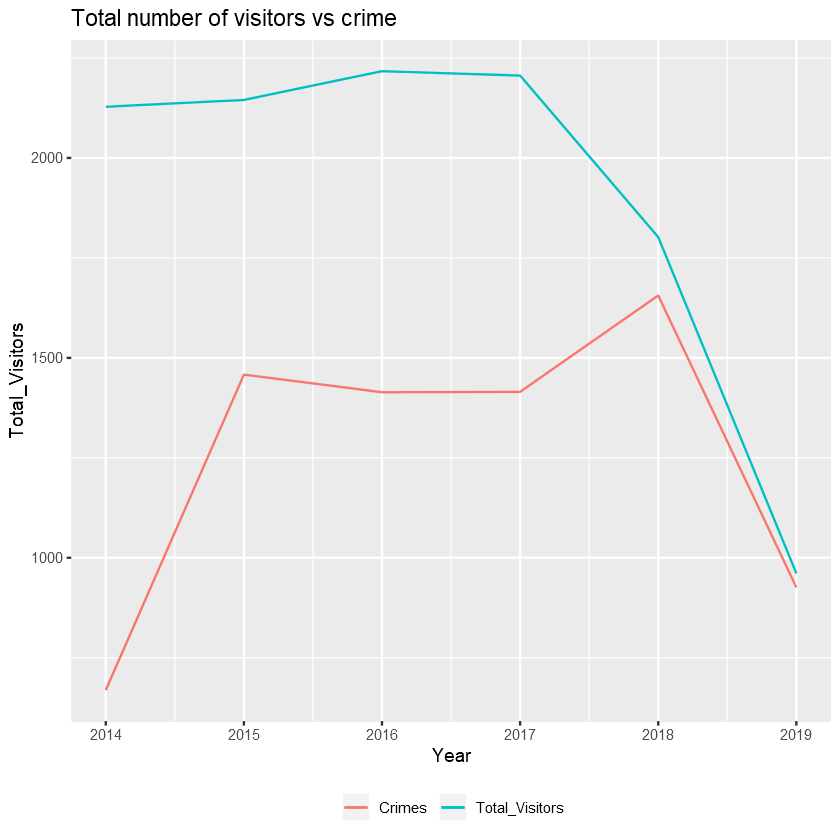

In [493]:
# Plotted total visitors and crime rate based on year

plot <- ggplot(visual, aes(x = Year)) + 
  geom_line(aes(y = Total_Visitors, colour = "Total_Visitors")) + 
  geom_line(aes(y = Crimes, colour = "Crimes")) +
  ggtitle("Total number of visitors vs crime") +
  theme(legend.position = "bottom")+
  labs(colour="")
plot + transition_reveal(Year)
plot

In [494]:
food_df <- read_csv("FoodPrice.csv")
rental_df <- read_csv("Rental.csv")

Parsed with column specification:
cols(
  Year = col_double(),
  Month = col_double(),
  Quarter = col_character(),
  Avg_Meal_Price = col_double()
)

Parsed with column specification:
cols(
  Year = col_double(),
  Month = col_double(),
  Quarter = col_character(),
  NZ_City = col_character(),
  Avg_rent = col_double()
)



In [495]:
# aggregated dataframe to find the average meal price
vis3 <- food_df %>%
            select(Year,Month,Quarter,Avg_Meal_Price) %>%
            group_by(Year,Month,Quarter) %>%
            summarise(Average_mealprice = mean(Avg_Meal_Price))
vis3 %>% glimpse

Observations: 244
Variables: 4
Groups: Year, Month [244]
$ Year              <dbl> 1999, 1999, 1999, 1999, 1999, 1999, 1999, 2000, 2...
$ Month             <dbl> 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9...
$ Quarter           <chr> "1999 Q2", "1999 Q3", "1999 Q3", "1999 Q3", "1999...
$ Average_mealprice <dbl> 616.3569, 617.1004, 617.1004, 619.3309, 620.0743,...


In [496]:
# aggregated dataframe to find the average rent price
vis4 <- rental_df %>%
            select(Year,Month,Quarter,Avg_rent) %>%
            group_by(Year,Month,Quarter) %>%
            summarise(Average_rentprice = mean(Avg_rent))
vis4 %>% glimpse

Observations: 321
Variables: 4
Groups: Year, Month [321]
$ Year              <dbl> 1993, 1993, 1993, 1993, 1993, 1993, 1993, 1993, 1...
$ Month             <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4...
$ Quarter           <chr> "1993 Q1", "1993 Q1", "1993 Q1", "1993 Q2", "1993...
$ Average_rentprice <dbl> 128.5441, 129.0597, 127.9565, 126.2222, 129.9000,...


In [497]:
# merged the dataframe to visulaize
visual_2 <- merge(vis3,vis4)
visual_2 %>% head

Year,Month,Quarter,Average_mealprice,Average_rentprice
<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1999,10,1999 Q4,620.0743,155.0694
1999,11,1999 Q4,620.0743,156.0986
1999,12,1999 Q4,620.0743,155.7917
1999,6,1999 Q2,616.3569,154.8750
1999,7,1999 Q3,617.1004,155.6301
1999,8,1999 Q3,617.1004,155.6528



Rendering [----------------------------------------------] at 2 fps ~ eta:  1m

Rendering [>-------------------------------------------] at 1.9 fps ~ eta:  1m

Rendering [=>------------------------------------------] at 1.8 fps ~ eta:  1m

Rendering [==>-----------------------------------------] at 1.8 fps ~ eta:  1m

Rendering [==>-------------------------------------------] at 2 fps ~ eta: 47s

Rendering [===>----------------------------------------] at 2.1 fps ~ eta: 44s

Rendering [===>----------------------------------------] at 2.2 fps ~ eta: 42s

Rendering [===>----------------------------------------] at 2.3 fps ~ eta: 40s

Rendering [====>---------------------------------------] at 2.3 fps ~ eta: 38s

Rendering [====>---------------------------------------] at 2.3 fps ~ eta: 39s

Rendering [=====>--------------------------------------] at 2.3 fps ~ eta: 38s

Rendering [=====>--------------------------------------] at 2.3 fps ~ eta: 37s

Rendering [======>---------------------

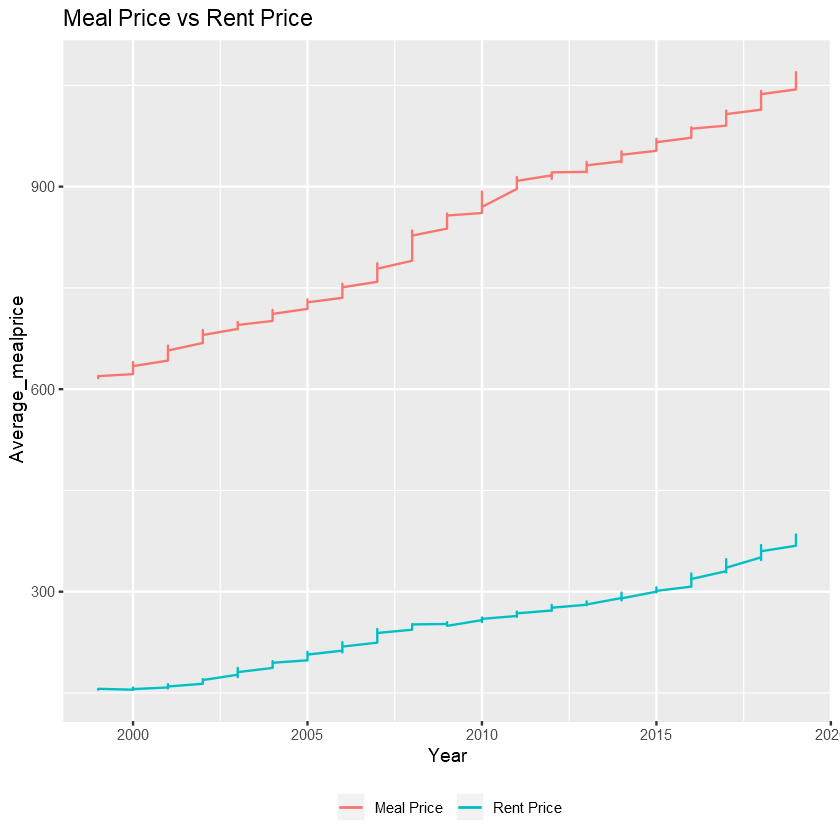

In [498]:
# plotted meal and rent price based on year

plot <- ggplot(visual_2, aes(x = Year)) + 
  geom_line(aes(y = Average_mealprice , colour = "Meal Price")) + 
  geom_line(aes(y = Average_rentprice, colour = "Rent Price")) +
  ggtitle("Meal Price vs Rent Price") +
  theme(legend.position = "bottom")+
  labs(colour="")
plot + transition_reveal(Year)
plot